In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [70]:
import pandas as pd
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
import scipy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [71]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))
from UKMovementSensing import hsmm
from milleniumcohort import create_config

In [72]:
config = create_config('../config.yml')
config.create_data_paths()

## Load data

In [73]:
# Import data with states
filenames = os.listdir(config.states_path)
filenames = [fn for fn in filenames if os.path.isfile(os.path.join(config.states_path,fn))]
datasets = [pd.read_csv(os.path.join(config.states_path,fn), encoding='utf-8', index_col='timestamp', parse_dates=True) for fn in filenames]

print(len(datasets))

4


In [74]:
#Concatenate all data together for analysis
all_data = pd.concat(datasets)

In [75]:
#Define consistent colormap
from matplotlib.colors import LinearSegmentedColormap
# One more than the number of states, so we have a color for 'All'
nr_states = all_data.state.nunique()
colormap, cmap = hsmm.get_color_map(nr_states+1)
cmap_states = LinearSegmentedColormap.from_list('name',
                                             [colormap[i] for i in range(nr_states)],
                                             nr_states)

In [76]:
# Load simplified activities map
activities_simplified = pd.read_csv(config.activities_simplified_path, header=0, sep=',', dtype=str)
levelmap = {'0': "low", '1': "high", '2':"mixed"}
def get_category_des(motion, arm_changes):
    return levelmap[motion]+" motion, " + levelmap[arm_changes] + " arm changes"
activities_simplified['simplified_category'] = [get_category_des(row[1], row[2]) for row in activities_simplified.get_values()]

all_data = all_data.merge(activities_simplified, left_on='label', right_on='Label', how='left')

In [77]:

heuristic_classes = ['1 - no activity',  #1
                     '2 - inactivity', #2
                     '3 - light activity', #3 
                     '4 - vigorous activity', #4
                    '5 - MVPA at least 10 min', #5
                    '6 - MVPA 1-10 min', #6
                    '7 - inactivity at least 30min'] #7 
all_data['cut-off'] = [heuristic_classes[int(i)-1] for i in all_data['heuristic']]

## Get subjects with >20 hour data

In [78]:
all_data.columns

Index([                                                u'EN',
                                               u'Unnamed: 0',
                                             u'acceleration',
                                                 u'activity',
                                                   u'anglex',
                                                   u'angley',
                                                   u'anglez',
                                                  u'binFile',
                                                      u'day',
                                       u'dev_roll_med_acc_x',
                                       u'dev_roll_med_acc_y',
                                       u'dev_roll_med_acc_z',
                                                 u'filename',
                                                u'heuristic',
                                                  u'invalid',
                                                    u'label',
        

In [79]:
timecounts = all_data.groupby('filename')['EN'].count()
timecounts.name = 'cnt_5s'
timecounts['cnt_hours'] = timecounts.as_matrix() / (12.0 * 60)

In [80]:
longdays = timecounts[timecounts['cnt_hours']>=24].index
data_longdays = all_data[[(f in longdays) for f in all_data['filename']]]

## Calculate per-state statistics

In [81]:
bystate = all_data.groupby('state')
means = bystate[config.hsmmconfig.column_names].mean().transpose()
means.style.background_gradient(cmap='coolwarm',axis=1)

state,0,1,2,3
acceleration,0.0095504,0.0144165,0.0685085,0.0227978


In [82]:
#Now for all columns
bystate = all_data.groupby('state')
numerical_columns = ['acceleration','EN',
        'anglex','angley',u'anglez',u'roll_med_acc_x',u'roll_med_acc_y',
        u'roll_med_acc_z',u'dev_roll_med_acc_x',
             u'dev_roll_med_acc_y',u'dev_roll_med_acc_z']
means = bystate[numerical_columns].mean().transpose()
means.style.background_gradient(cmap='coolwarm',axis=1)

state,0,1,2,3
acceleration,0.0095504,0.0144165,0.0685085,0.0227978
EN,1.00372,1.00872,1.03826,1.01034
anglex,-18.2311,-17.8243,-37.2502,-24.9715
angley,30.6641,30.5007,-0.984636,18.638
anglez,-17.2371,-18.5183,-10.8214,-14.6695
roll_med_acc_x,-0.272829,-0.270428,-0.518721,-0.36292
roll_med_acc_y,0.43119,0.429072,-0.00204847,0.264844
roll_med_acc_z,-0.269521,-0.287229,-0.164734,-0.228072
dev_roll_med_acc_x,0.00057757,0.000523692,0.000594606,0.00108912
dev_roll_med_acc_y,-0.000793686,-0.00136397,-0.00336707,-0.00136364


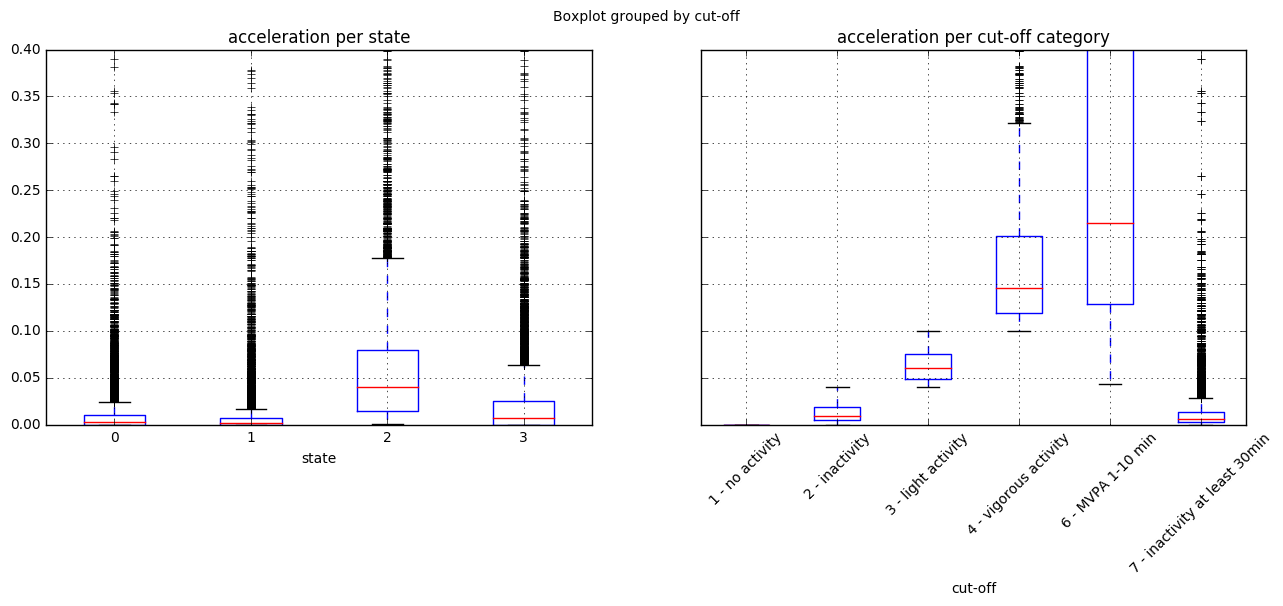

In [84]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15, 5))
fig.set_label('')
ymax = 0.4
all_data.boxplot(by='state', column=config.hsmmconfig.column_names, ax=axes[0])
axes[0].set_ylim(top=ymax)
axes[0].set_title('acceleration per state')
all_data.boxplot(by='cut-off', column=config.hsmmconfig.column_names, ax=axes[1], rot=45)
axes[1].set_ylim(top=ymax)
axes[1].set_title('acceleration per cut-off category')
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f22bd283250>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f22c22b4e10>]], dtype=object)

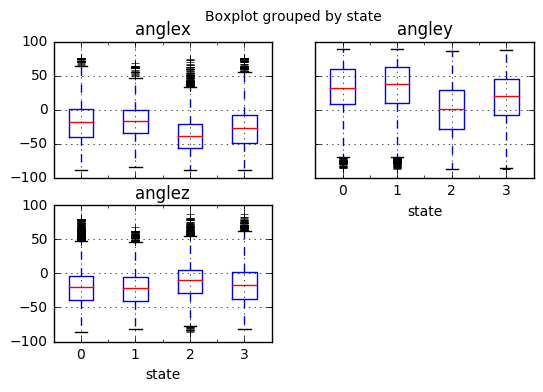

In [85]:
all_data.boxplot(by='state', column=['anglex', 'angley', 'anglez'])

## Get sojourn times

In [86]:
def sojourn_times(df, colname):
    changepoints = (df[colname].shift(1) != df[colname]) | (df.filename.shift(1) != df.filename)
    df['block'] = changepoints.astype(int).cumsum()
    sojourn_times = df.groupby([colname, 'block'])['EN'].count()
    sojourn_times = sojourn_times.reset_index()[[colname, 'EN']]
    sojourn_times.columns = [colname, 'time']
    df.drop('block', 1)
    return sojourn_times

In [87]:
sojourn_times_state = sojourn_times(all_data, 'state')
sojourn_times_cutoff = sojourn_times(all_data, 'cut-off')

In [88]:
sojourn_times_cutoff.head()

,cut-off,time
0,1 - no activity,129
1,1 - no activity,65
2,1 - no activity,148
3,1 - no activity,62
4,1 - no activity,104


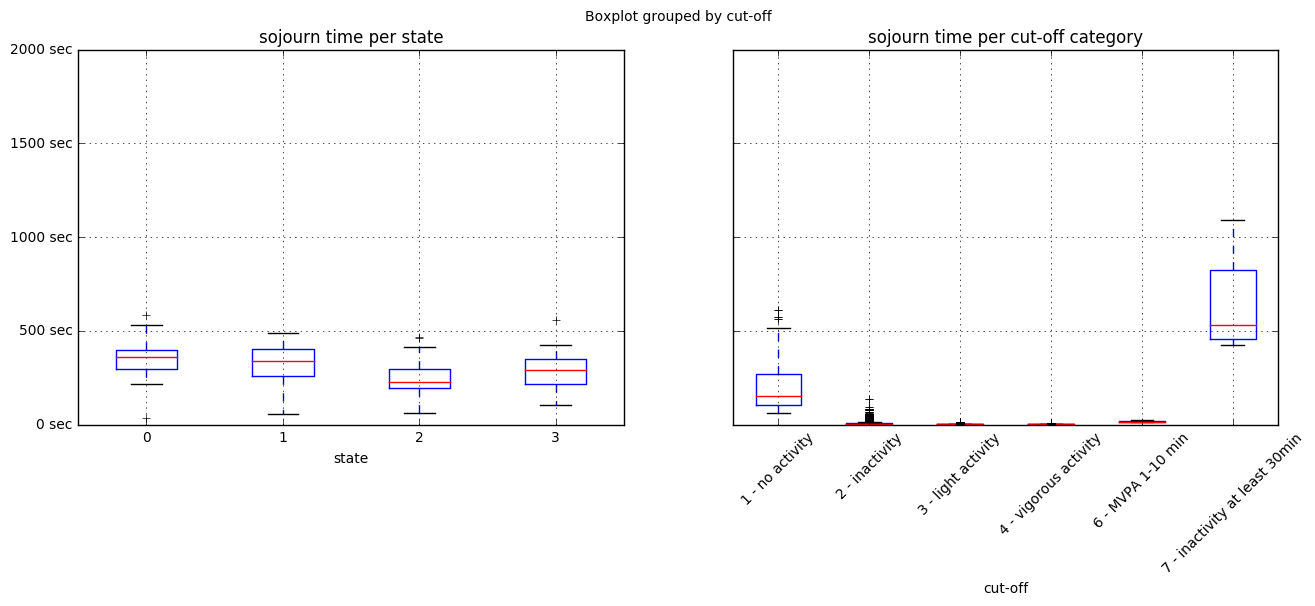

In [89]:
from matplotlib.ticker import FormatStrFormatter
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15, 5))
fig.set_label('')
ymax = 2000
sojourn_times_state.boxplot(by='state', column='time', ax=axes[0])
axes[0].set_ylim(top=ymax)
axes[0].yaxis.set_major_formatter(FormatStrFormatter('%d sec'))
axes[0].set_title('sojourn time per state')
sojourn_times_cutoff.boxplot(by='cut-off', column='time', ax=axes[1], rot=45)
axes[1].set_ylim(top=ymax)
axes[1].set_title('sojourn time per cut-off category')
plt.show()

## Cross table activity - state

Let's compare the states with the known activities. First we have look at how many 5-seconds frame we have for each state/activity, and we sort from largest to smallest

In [90]:
ctab = pd.crosstab(all_data['label'], all_data['state'], margins=True).sort_values('All', ascending=False)

In [91]:
all_data_sub = all_data[all_data['Keep variable']=='TRUE']

In [92]:
ctab_simplified = pd.crosstab(all_data_sub['simplified_category'], all_data_sub['state'], 
                              margins=True).sort_values('All', ascending=False)

In [93]:
ctab_simplified

state,0,1,2,3,All
simplified_category,,,,,
All,14151,8439,5545,9305,37440
"low motion, low arm changes",7508,4745,589,3838,16680
"low motion, mixed arm changes",2310,1187,2612,2291,8400
"low motion, high arm changes",2834,1537,514,1235,6120
"mixed motion, high arm changes",1271,623,1324,1102,4320
"high motion, high arm changes",228,347,506,839,1920


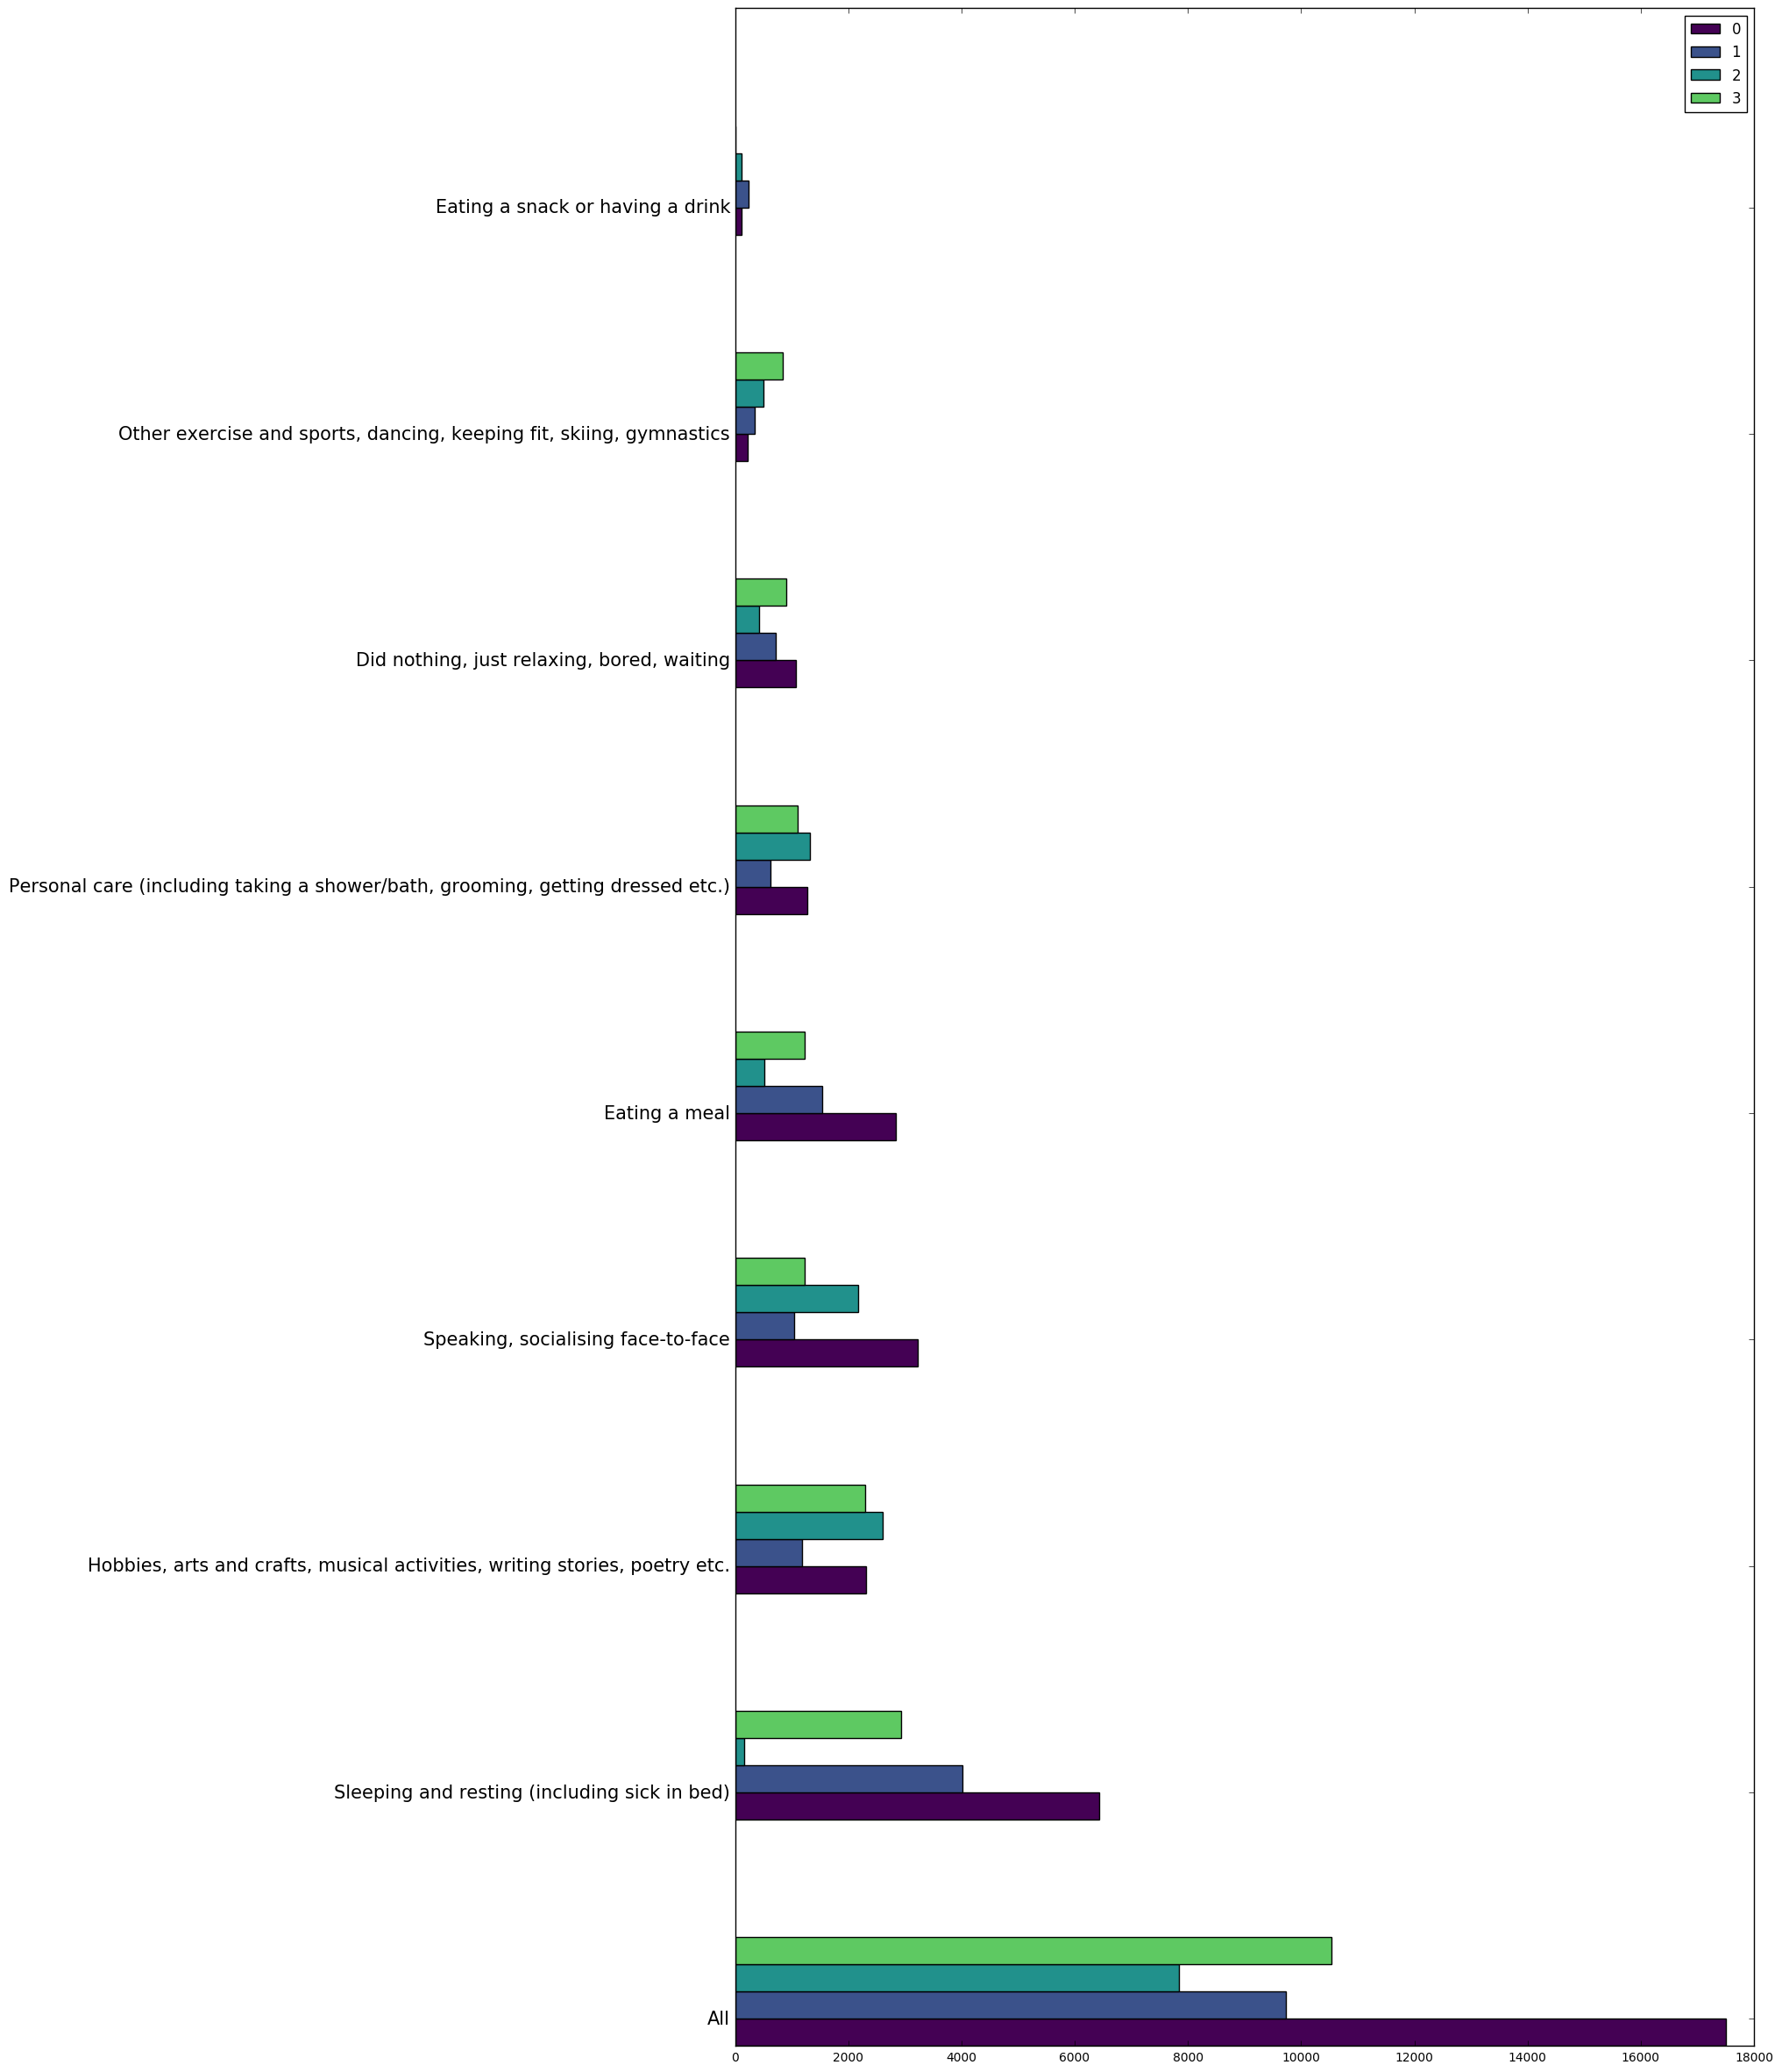

In [94]:
from __future__ import unicode_literals
fig, ax = plt.subplots(figsize=(15,30))

states = ctab.columns
acts = ctab.index

n_groups = len(acts)
index = len(states)*np.arange(n_groups)
bar_width = 1./len(states)*3
colors = colormap

#Draw all states, but don't draw All
for i in range(len(states)-1):
    rects1 = plt.barh(index + i*bar_width, 
                     ctab[states[i]], 
                     bar_width,
                     color=colors[i],
                     label=states[i])

plt.yticks(index + bar_width, ctab.index, fontsize=15)
plt.legend()

#Set maximum to something reasonable, namely the maximum of not-all
#ax.set_xlim(0, ctab[states[-1]][acts[1]])
plt.show()

In [95]:
#Now normalize over the activity and sort by total number
data = all_data_sub
label = 'simplified_category' #'act_label'
ind = list(ctab_simplified.index)
ctab_norm1 = pd.crosstab(data[label], data['state'], normalize='index', margins=True).loc[ind]

In [96]:
ctab_norm1.style.background_gradient(cmap='BuGn',axis=1)

state,0,1,2,3
simplified_category,,,,
All,0.377965,0.225401,0.148104,0.248531
"low motion, low arm changes",0.45012,0.284472,0.0353118,0.230096
"low motion, mixed arm changes",0.275,0.14131,0.310952,0.272738
"low motion, high arm changes",0.463072,0.251144,0.0839869,0.201797
"mixed motion, high arm changes",0.294213,0.144213,0.306481,0.255093
"high motion, high arm changes",0.11875,0.180729,0.263542,0.436979


In [97]:
ctab_norm1.to_clipboard()

In [98]:
#Now normalize over state and sort by total number
#ind = list(ctab.index)
ctab_norm2 = pd.crosstab(all_data[label], all_data['state'], normalize='columns', margins=True).loc[ind]
ctab_norm2 = ctab_norm2.fillna(0)

In [99]:
ctab_norm2.style.background_gradient(cmap='BuGn',axis=0)

state,0,1,2,3,All
simplified_category,,,,,
All,0,0,0,0,0
"low motion, low arm changes",0.429053,0.487617,0.0751563,0.364379,0.365789
"low motion, mixed arm changes",0.132008,0.121981,0.333291,0.217507,0.184211
"low motion, high arm changes",0.161952,0.157949,0.0655863,0.117251,0.134211
"mixed motion, high arm changes",0.0726327,0.0640222,0.168942,0.104624,0.0947368
"high motion, high arm changes",0.0130293,0.0356592,0.0645655,0.0796544,0.0421053


Check if there is a significant correlation between the states and the activities:

In [100]:
topactivities = 10 # take most frequent activities
counts = ctab.as_matrix()[1:1+topactivities,:-1]
chi2, p, dof, expected = scipy.stats.chi2_contingency(counts)

print(chi2, p)

7501.79534203 0.0


In [101]:
ctab.head(10)

state,0,1,2,3,All
label,,,,,
All,17499,9731,7837,10533,45600
Sleeping and resting (including sick in bed),6436,4020,166,2938,13560
"Hobbies, arts and crafts, musical activities, writing stories, poetry etc.",2310,1187,2612,2291,8400
"Speaking, socialising face-to-face",3228,1052,2172,1228,7680
Eating a meal,2834,1537,514,1235,6120
"Personal care (including taking a shower/bath, grooming, getting dressed etc.)",1271,623,1324,1102,4320
"Did nothing, just relaxing, bored, waiting",1072,725,423,900,3120
"Other exercise and sports, dancing, keeping fit, skiing, gymnastics",228,347,506,839,1920
Eating a snack or having a drink,120,240,120,0,480


In [102]:
# Only easy interpreted activities
activities = ['Sleeping and resting (including sick in bed)', 'Jogging, running, walking, hiking']
ctab[[a in activities for a in ctab.index]]

state,0,1,2,3,All
label,,,,,
Sleeping and resting (including sick in bed),6436,4020,166,2938,13560


## Compare with heuristic

In [103]:
ctab_heuristic = pd.crosstab(all_data['heuristic'], all_data['state'], margins=True)
ctab_heuristic = ctab_heuristic.fillna(0)

In [104]:
heuristic_classes = ['no activity',  #1
                     'inactivity', #2
                     'light activity', #3 
                     'moderate/vigorous activity', #4
                    'MVPA at least 10 min', #5
                    'MVPA 1-10 min', #6
                    'inactivity at least 30min'] #7 
ctab_heuristic.index = [heuristic_classes[i-1] for i in ctab_heuristic.index[:-1]] + [ctab_heuristic.index[-1]]

In [105]:
ctab_heuristic.style.background_gradient(cmap='BuGn',axis=0)

state,0,1,2,3,All
no activity,8082,5421,0,3409,16912
inactivity,4678,2133,3399,4850,15060
light activity,597,403,2307,1351,4658
moderate/vigorous activity,116,201,1226,513,2056
MVPA 1-10 min,0,54,181,33,268
inactivity at least 30min,6664,3198,734,1570,12166
All,20137,11410,7847,11726,51120


In [106]:
ctab_heuristic.applymap(lambda c: '{:.0f} min'.format(c/(12.0)))

state,0,1,2,3,All
no activity,674 min,452 min,0 min,284 min,1409 min
inactivity,390 min,178 min,283 min,404 min,1255 min
light activity,50 min,34 min,192 min,113 min,388 min
moderate/vigorous activity,10 min,17 min,102 min,43 min,171 min
MVPA 1-10 min,0 min,4 min,15 min,3 min,22 min
inactivity at least 30min,555 min,266 min,61 min,131 min,1014 min
All,1678 min,951 min,654 min,977 min,4260 min


## Heuristic vs states, per person

In [107]:
#do this for only files with >20 hr
times = data_longdays.groupby(['filename', 'state', 'cut-off'])['start_time'].count()
times.name = 'cnt'
times = times.reset_index()

In [108]:
nr_subjects = len(times['filename'].unique())
ctab = times.groupby(['state', 'cut-off'])['cnt'].sum()
ctab = ctab / nr_subjects
ctab = ctab.unstack(level=-1)
ctab = ctab.fillna(0)
ctab['total'] = times.groupby(['state'])['cnt'].sum() / nr_subjects
ctab.loc['total',] = ctab.sum(axis=0) 
ctab.applymap(lambda c: float(c)/nr_subjects)
ctab = ctab.applymap(lambda c: '{:.0f} min'.format(c/12.0))

In [109]:
ctab

cut-off,1 - no activity,2 - inactivity,3 - light activity,4 - vigorous activity,6 - MVPA 1-10 min,7 - inactivity at least 30min,total
state,,,,,,,
0,337 min,195 min,25 min,5 min,0 min,278 min,839 min
1,226 min,89 min,17 min,8 min,2 min,133 min,475 min
2,0 min,142 min,96 min,51 min,8 min,31 min,327 min
3,142 min,202 min,56 min,21 min,1 min,65 min,489 min
total,705 min,628 min,194 min,86 min,11 min,507 min,2130 min


## Distributions for the heuristic levels

In [111]:
bystate = all_data.groupby('heuristic')
means = bystate[config.hsmmconfig.column_names].mean().transpose()
stds = bystate[config.hsmmconfig.column_names].std().transpose()
concat = pd.concat([means, stds], axis=0, keys=['mean', 'sigma'])
concat = concat.reorder_levels(order=[1,0], axis=0)
concat.columns = [heuristic_classes[i-1] for i in concat.columns]
concat.style.background_gradient(cmap='coolwarm',axis=1)

In [112]:
concat.to_clipboard()

## States for an example sequence

In [113]:
example_index = 0
data = datasets[example_index]
hidden_states = data['state']

(<matplotlib.figure.Figure at 0x7f22bd18c190>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f22c2ad9d10>)

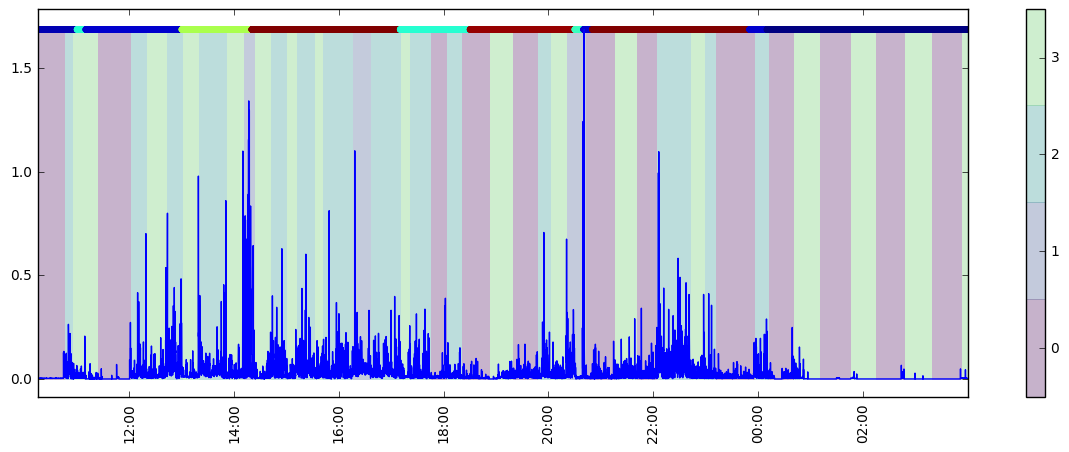

In [114]:
hsmm.plot_states_and_var(data, hidden_states, columns=['acceleration',], by='activity', cmap=cmap_states)

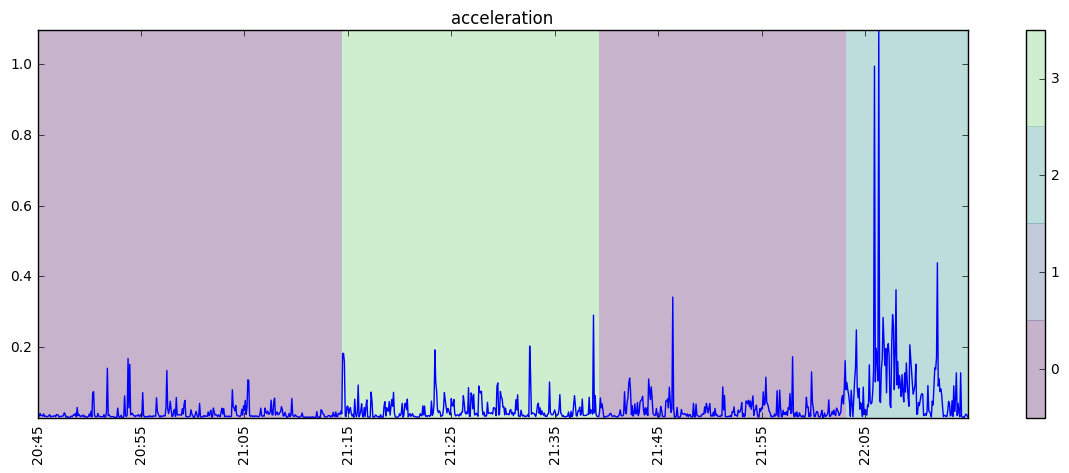

In [115]:
start =int(10.5*12*60)
end = 12*12*60
fig, ax = hsmm.plot_states_and_var(data[start:end], hidden_states[start:end], cmap=cmap_states, columns=['acceleration'], by=None)
ax.set_title('acceleration')
plt.show()

(<matplotlib.figure.Figure at 0x7f22c1864d50>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f22c161cdd0>)

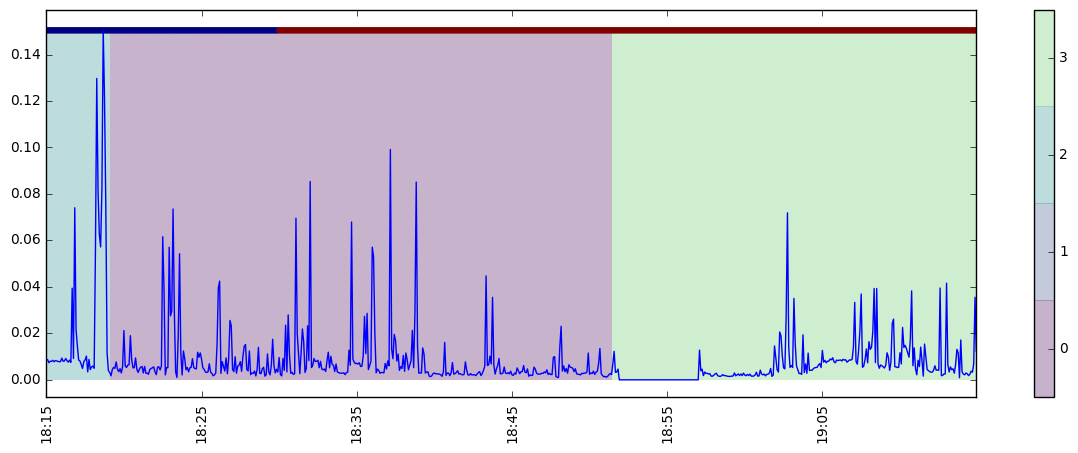

In [116]:
start =int(8*12*60)
end = 9*12*60
hsmm.plot_states_and_var(data[start:end], hidden_states[start:end], cmap=cmap_states, columns=['acceleration'], by='activity')

(<matplotlib.figure.Figure at 0x7f22c16d2a50>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f22c170b350>)

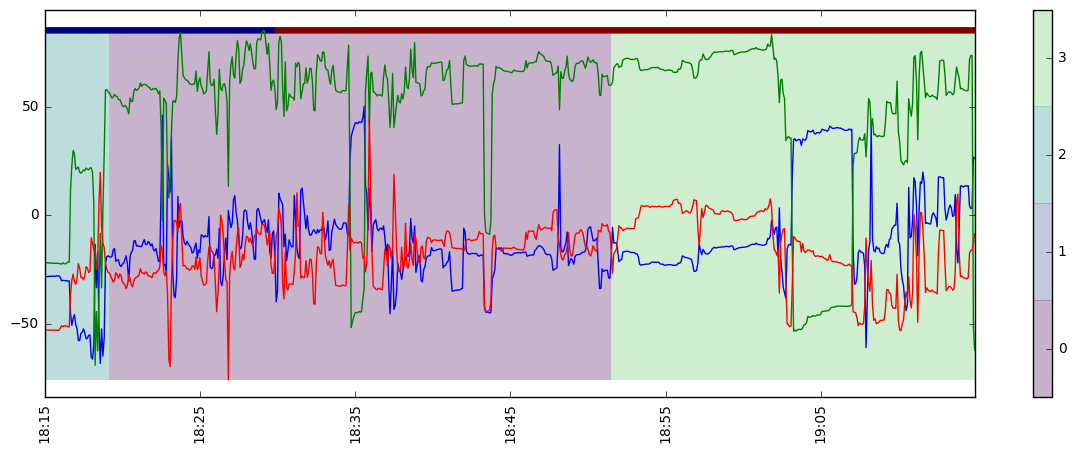

In [117]:
hsmm.plot_states_and_var(data[start:end], hidden_states[start:end], cmap=cmap_states, columns=['anglex', 'angley', 'anglez'], by='activity')